In [ ]:
# import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
def make_X(flow):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=pd.read_csv("Pred1.txt",index_col=0)
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,1501,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf,sort=False)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf,sort=False)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf

tf.reset_default_graph()


af=pd.read_csv("CRI.csv")
af.drop(columns=["Unnamed: 0","ID"],inplace=True)
X=af.iloc[:,:-1].values
y=[[e] for e in af.InjQ.values]




tf_x = tf.placeholder(tf.float32, [None,20], name="tf_x")     # 输入量 占位符 特征是多少维的，这里就定义多少维
tf_y = tf.placeholder(tf.float32, [None,1], name="tf_y")     # 输出量
isTraing=tf.placeholder(tf.bool, name="isTraing")
# neural network layers
#l1 = tf.layers.dense(tf_x,30,None)
l1 = tf.layers.batch_normalization(tf_x,training=isTraing) # 将输入量归一化（或者叫标准化）
l1 = tf.layers.dense(l1,128,tf.nn.relu) #添加一个隐藏层，并指定神经元个数以及激活函数
l1 = tf.layers.batch_normalization(l1,training=isTraing) # 将输入量归一化（或者叫标准化）
#drop_out = tf.nn.dropout(l1, 0.3) # 去除一部分连接，防止过拟合
l1 = tf.layers.dense(l1,128,tf.nn.relu)
l1 = tf.layers.batch_normalization(l1,training=isTraing) # 将输入量归一化（或者叫标准化）
#drop_out = tf.nn.dropout(l1, 0.3) # 去除一部分连接，防止过拟合
l1 = tf.layers.dense(l1,128,tf.nn.relu)
l1 = tf.layers.batch_normalization(l1,training=isTraing) # 将输入量归一化（或者叫标准化）
#drop_out = tf.nn.dropout(l1, 0.3) # 去除一部分连接，防止过拟合
output = tf.layers.dense(l1, 1,name='output')                     # 输出层，仅有一个输出
#x_norm = tf.layers.batch_normalization(tf_x, training=False)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # 配合标准化必须的操作
#cross_entropy = -tf.reduce_sum(tf_y*tf.log(output))
loss = tf.losses.mean_squared_error(tf_y, output)   # MSE==均方差作为误差函数
#eloss = tf.metrics.mean_squared_error(tf_y,output)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
#train_op = optimizer.minimize(loss)
def get_batch(raw_X,raw_y,size=100):
    '''
    从原始数据中随机挑出size=size个数据
    '''
    idx=np.random.choice(range(len(raw_X)),size,replace=False)
    X=[raw_X[x] for x in idx]
    y=[raw_y[x] for x in idx]
    return X,y

train_X,test_X, train_y, test_y=train_test_split(X,y,test_size = 0.2)

#X_train,y_train=get_batch(train_X,train_y,size=1024)
with tf.control_dependencies(update_ops):
    #train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
    train_step = tf.train.AdamOptimizer(0.01).minimize(loss)
sess = tf.Session()                                 # 建立和Session的连接
sess.run(tf.global_variables_initializer())         # 初始化计算图中的变量



lo=[] # 保存所有的历史成本
Va=[]
for step in range(3000+1): # 迭代训练次数
    # train and net output    
    X_train,y_train=get_batch(train_X,train_y,size=4096) # 获取随机批次的数据，准备喂给tensorflow
    #print(X_train.shape)
    #print(y_train.shape)
    _, l, pred = sess.run([train_step, loss, output], feed_dict={tf_x: X_train, tf_y: y_train,isTraing:True})
    #sess.run(train_step, feed_dict={tf_x: X_train, tf_y: y_train})
    #sess.run(train_op, feed_dict={tf_x: X, tf_y: y})
    Val_loss=sess.run(loss,feed_dict={tf_x:test_X,tf_y:test_y,isTraing:False})

    
    lo.append(l)
    Va.append(Val_loss)
    
    #total_error = tf.reduce_sum(tf.square(tf.sub(tf_y, tf.reduce_mean(tf_y))))
    #R_squared = tf.sub(1, tf.div(unexplained_error, total_error))
    #r2_score(y_test,y_predict)
    if(np.isnan(l)):
        raise("NaN")
    #if step % 100 == 0:        
    print('\rTraining loss is:{0: 9.3f}, CV loss is:{1: 9.3f} at step {2}'.format( l ,Val_loss, step),end='')
    if(Val_loss<0.1):
        print('\nTraining stopped.\nTraining loss is:{0: 9.3f}, CV loss is:{1: 9.3f} at step {2}'.format( l ,Val_loss, step))
        break #Stop iteration   
#print("Validation Loss:",sess.run(loss,feed_dict={tf_x:test_X,tf_y:test_y,isTraing:False}))
saver=tf.train.Saver()
saver.save(sess,'./testsaver.cpkt')
plt.style.use('ggplot') # plot style 使用 ggplot
plt.figure(figsize=(8, 6))
tp=plt.plot(range(len(lo)),lo,c='b',label="Train Loss") # 画出成本随训练次数的变化
ts=plt.plot(range(len(lo)),Va,c='r',label="Test loss") # 画出测试随训练次数的变化
plt.title("Loss change ")
plt.xlabel("Training times")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend(["Train loss",'Test loss'],loc='best')
plt.show()

plt.figure(figsize=(8, 21))

#output_pred = sess.run(output,{tf_x:x_pred})
flows=[350,400,500]
for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    X_new=make_X(flows[i])
    y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for nozzle flow rate: {}".format(flows[i]))


In [ ]:
'''
def make_X(*args, **kargs):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    
    
    pars=['Tem.', 'Inj. Back pressure', 'Cylinder', 'No. of Plunger',
       'No. of Lobe', 'Devolume ', 'Plunger lift_mm', 'Needle Lift',
       'Nozzle Flow Rate_ cm3/30s@100bar', 'holes Num.', 'DSP', 'Volume',
       'HPP P2R_Length', 'HPP P2R_ID', 'HPP P2R_OD', 'HPP R2I_Length',
       'HPP R2I_ID', 'HPP R2I_OD']
    
    

    tlf=pd.read_csv("Pred.csv",index_col=0)
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,1501,3)]
    RailP=[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf,sort=False)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf,sort=False)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    #tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    for key in kargs:
        if key in pars:
            tf[key]=args[key]
    return tf

'''

#flows=[400,500]
flows=[300,400,500]
fig=plt.figure(figsize=(8,7*len(flows)))
for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    pars={'Nozzle Flow Rate_ cm3/30s@100bar':flows[i]}
    X_new=make_X(pars)
    y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ax.set_ylabel("Injected Q.")
    #plt.xlim(0,300)
    #plt.ylim(0,10)
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for {0}: {1}".format(list(pars.keys())[0],flows[i]),
           )
#X_new.iloc[0].index

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
sess=tf.Session()

#s=tf.train.Saver()
#s.restore(sess,'./ET_tensorflow_40x40x40')


#tf.reset_default_graph()



# Add ops to save and restore all the variables.
saver = tf.train.import_meta_graph('./testsaver.cpkt.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))
sess = tf.Session()
saver.restore(sess, "./testsaver.cpkt")
'''
import tensorflow as tf
saver = tf.train.import_meta_graph("./testsaver.cpkt.meta")
sess = tf.Session()
saver.restore(sess, "./model_ex1")
result = sess.run("v4:0", feed_dict={"v1:0": 12.0, "v2:0": 3.3})
print(result)

'''
print("Model restored.")


INFO:tensorflow:Restoring parameters from ./testsaver.cpkt
INFO:tensorflow:Restoring parameters from ./testsaver.cpkt
Model restored.


In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def make_X(*args, **kargs):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    
    
    pars=['Tem.', 'Inj. Back pressure', 'Cylinder', 'No. of Plunger',
       'No. of Lobe', 'Devolume ', 'Plunger lift_mm', 'Needle Lift',
       'Nozzle Flow Rate_ cm3/30s@100bar', 'holes Num.', 'DSP', 'Volume',
       'HPP P2R_Length', 'HPP P2R_ID', 'HPP P2R_OD', 'HPP R2I_Length',
       'HPP R2I_ID', 'HPP R2I_OD']
    
    

    tlf=pd.read_csv("Pred.txt",index_col=0)
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,1501,3)]
    RailP=[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf,sort=False)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf,sort=False)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    #tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    for key in kargs:
        if key in pars:
            tf[key]=args[key]
    return tf


saver = tf.train.Saver()  # Gets all variables in `graph`.
sess=tf.Session()
sess.run(tf.global_variables_initializer())





saver.restore(sess,'./40x3_relu.mod')
# Do some work with the model....


#flows=[400,500]
flows=[200,300,500]
fig=plt.figure(figsize=(8,7*len(flows)))
for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    pars={'HPP P2R_Length':flows[i]}
    X_new=make_X(pars)
    y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')

    ff.columns=ff.columns.droplevel()
    ax.set_ylabel("Injected Q.")
    #plt.xlim(0,300)
    #plt.ylim(0,10)
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for {0}: {1}".format(list(pars.keys())[0],flows[i]),
           )
#X_new.iloc[0].index



In [ ]:
def make_X(flow):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=pd.read_csv("Pred1.txt",index_col=0)
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,1504,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf,sort=False)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf,sort=False)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf

plt.figure(figsize=(8, 21))
flows=[350,440,500]
for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    X_new=make_X(flows[i])
    y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.to_csv("Changfa"+str(flows[i])+".csv")
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for nozzle flow rate: {}".format(flows[i]))
    #plt.scatter(1499,y0,s = 50,color = 'r',lw= 2)#散列要标注的坐标点

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tlf=pd.read_csv("Pred_Changfa.csv",index_col=0)
def make_X(row):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=row
    tlf.drop(columns=["InjQ"],inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(121,1304,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf,sort=False)
    tlf.drop(columns=["ET","RailP"],inplace=True)
    #print(names)
    tf=tlf.append(tf,sort=False)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    #tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf
d=[]
for index, row in tlf.iterrows():
    #print(make_X(pd.DataFrame(row)))
    a=pd.DataFrame(row)
    f=make_X(a.T)
plt.figure(figsize=(8, 7*tlf.shape[0]))
idx=0
for i, row in tlf.iterrows():    # 预测并画图
    idx+=1
    ax = plt.subplot( tlf.shape[0],1,idx)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    a=pd.DataFrame(row)
    #=make_X()
    X_new=make_X(a.T)
    y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    flow=row['Nozzle Flow Rate_ cm3/30s@100bar']
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.to_csv("Changfa"+str(int(flow))+".csv")
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP, NFR = {0:g}".format(flow))
    #plt.scatter(1499,y0,s = 50,color = 'r',lw= 2)#散列要标注的坐标点

In [ ]:
for i in range(5000):
    epx,epy=getepoch(size=2048)
    train_model(model,feed={x:epx,y:epy})
    optim_model(model)
    TraingLoss=mean_squared_error(model.run(feed={x:epx,y:epy}))
    TestLoss=mean_squared_error(model.run(feed={x:testx,y:testy}))
    if TestLoss<2:
        break
    if i % 200 ==0:
        print("Train loss:",TraingLoss)
        print("Test loss:",TestLoss)

Epoch 1/50
 - 12s - loss: 45.1201 - mean_absolute_error: 3.0473
Epoch 2/50
 - 9s - loss: 5.2425 - mean_absolute_error: 1.6008
Epoch 3/50
 - 9s - loss: 4.9321 - mean_absolute_error: 1.5416
Epoch 4/50
 - 10s - loss: 4.6972 - mean_absolute_error: 1.4927
Epoch 5/50
 - 10s - loss: 3.9680 - mean_absolute_error: 1.3759
Epoch 6/50
 - 9s - loss: 3.6330 - mean_absolute_error: 1.3267
Epoch 7/50
 - 9s - loss: 3.5212 - mean_absolute_error: 1.3057
Epoch 8/50
 - 8s - loss: 3.7349 - mean_absolute_error: 1.3532
Epoch 9/50
 - 9s - loss: 3.5145 - mean_absolute_error: 1.3144
Epoch 10/50
 - 9s - loss: 3.2887 - mean_absolute_error: 1.2768
Epoch 11/50
 - 9s - loss: 3.5608 - mean_absolute_error: 1.3172
Epoch 12/50
 - 8s - loss: 3.2558 - mean_absolute_error: 1.2523
Epoch 13/50
 - 9s - loss: 3.0178 - mean_absolute_error: 1.2214
Epoch 14/50
 - 10s - loss: 3.0003 - mean_absolute_error: 1.2217
Epoch 15/50
 - 10s - loss: 2.8932 - mean_absolute_error: 1.2011
Epoch 16/50
 - 11s - loss: 2.8545 - mean_absolute_error: 1

C:\Users\taz3wx\AppData\Local\conda\conda\envs\myroot\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


done


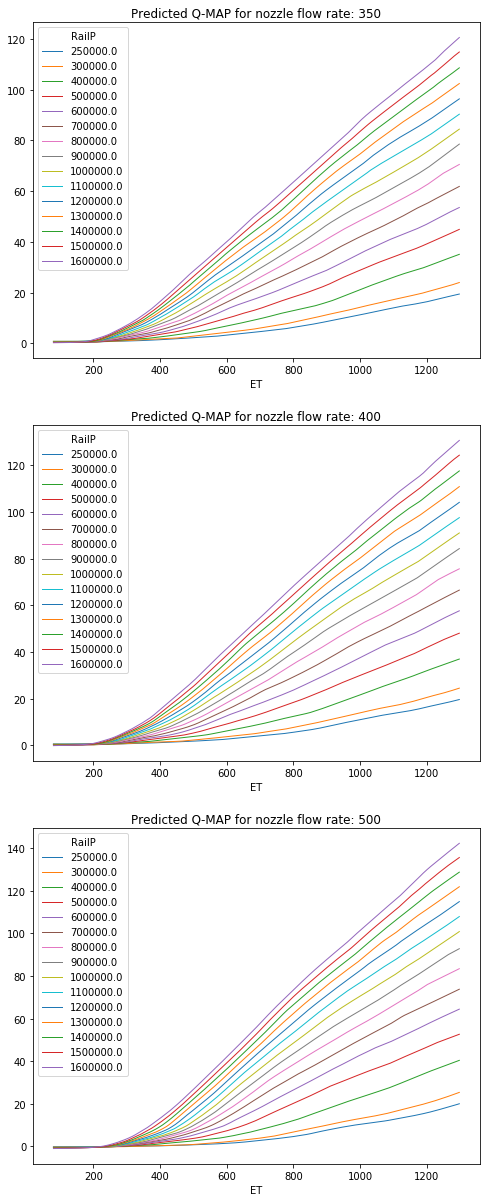

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
def make_X(flow):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=pd.read_csv("Pred1.txt",index_col=0)
    tlf.drop(labels=["InjQ"],axis=1,inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(80,1301,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        tf=tf.append(ttf)
    tlf.drop(labels=["ET","RailP"],axis=1,inplace=True)
    #print(names)
    tf=tlf.append(tf)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf
def LeakyRelu(x, leak=0.2, name="LeakyRelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * tf.abs(x)
model = keras.models.Sequential([
    # Adds a densely-connected layer with 64 units to the model:
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=LeakyRelu),
    #keras.layers.Dropout(0.3),
    # Add another:
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=LeakyRelu),
    #keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=LeakyRelu),
    #keras.layers.Dropout(0.1),
# Add another:
#model.add(keras.layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
    keras.layers.Dense(1),
])
# Configure a model for mean-squared error regression.
model.compile(optimizer='nadam',
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error
# Instantiates a toy dataset instance:


af=pd.read_csv("CRI.csv")
af.drop(labels=["Unnamed: 0","ID"],axis=1,inplace=True)
X=af.iloc[:,:-1].values
y=af.InjQ.values
data,val_data, labels, val_labels=train_test_split(X,y,test_size = 0.05)



callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  keras.callbacks.EarlyStopping(patience=2, monitor='loss'),
  # Write TensorBoard logs to `./logs` directory
  #keras.callbacks.TensorBoard(log_dir='./logs')
]
# Don't forget to specify `steps_per_epoch` when calling `fit` on a dataset.
model.fit(X,y, 
          epochs=50,
          batch_size=512,
          verbose=2,
          #validation_data=(val_data,val_labels),
          callbacks=callbacks
          )
plt.figure(figsize=(8, 21))

#output_pred = sess.run(output,{tf_x:x_pred})
flows=[350,400,500]
for i in range(len(flows)):    # 预测并画图
    ax = plt.subplot( len(flows),1,i+1)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    X_new=make_X(flows[i])
    y_pred = model.predict(X_new) #sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    X_new['InjQ']=y_pred
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.plot(ax=ax,linewidth=1,
            title="Predicted Q-MAP for nozzle flow rate: {}".format(flows[i]))

print('done')

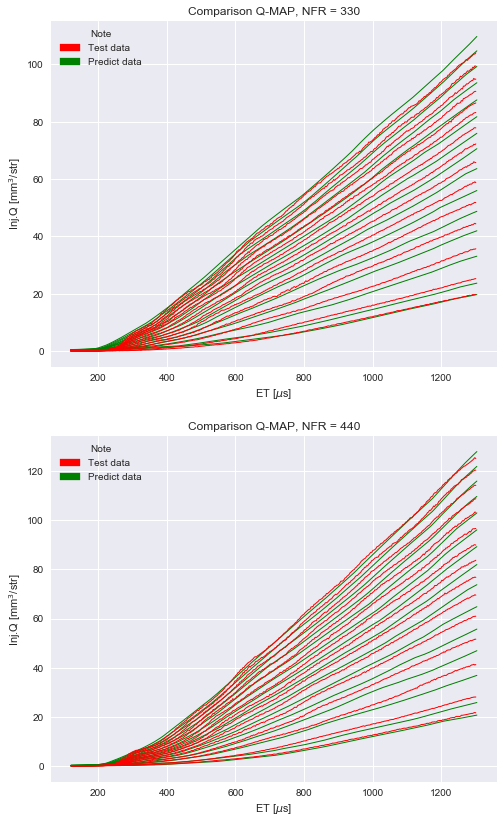

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow import keras
tlf=pd.read_csv("Pred_Changfa.csv",index_col=0)
def make_X(row):
    '''生成预测的数据
    参数是nozzle flow
    以后会扩充到所有可输入参数
    '''
    tlf=row
    tlf.drop(labels=["InjQ"],axis=1,inplace=True)
    names=tlf.columns.values
    ETs=[e for e in range(121,1304,3)]
    RailP=[250000]+[p for p in range(300000,1700000,100000)]
    tf=pd.DataFrame()
    es=pd.Series(ETs)
    ps=pd.Series({"RailP":RailP})
    for p in RailP:
        ttf=pd.DataFrame(es,columns=["ET"])
        ttf['RailP']=p
        #tf=tf.append(ttf,sort=False)
        tf=tf.append(ttf)
    tlf.drop(labels=["ET","RailP"],axis=1,inplace=True)
    #print(names)
    #tf=tlf.append(tf,sort=False)
    tf=tlf.append(tf)
    tf.fillna(method='ffill',inplace=True)
    tf.dropna(how='any',axis=0,inplace=True)
    tf = tf.reindex(columns=names)    
    #tf['Nozzle Flow Rate_ cm3/30s@100bar']=flow
    
    return tf

plt.style.use('seaborn')
d=[]
for index, row in tlf.iterrows():
    #print(make_X(pd.DataFrame(row)))
    a=pd.DataFrame(row)
    f=make_X(a.T)
plt.figure(figsize=(8, 7*tlf.shape[0]))
idx=0

for i, row in tlf.iterrows():    # 预测并画图
    idx+=1
    ax = plt.subplot( tlf.shape[0],1,idx)
    #plt.setp(ax)
    #plt.title("Nozzle:%d" % flows[i])
    a=pd.DataFrame(row)
    #=make_X()
    X_new=make_X(a.T)
    #y_pred = sess.run(output,{tf_x:X_new,isTraing:False})
    #y_pred=model.predict(X_new.values)
    y_pred=model.predict(X_new)
    X_new['InjQ']=y_pred
    flow=row['Nozzle Flow Rate_ cm3/30s@100bar']
    #X_new.loc[X_new.InjQ<0,'InjQ']=0
    pF=X_new.loc[:,["ET","RailP","InjQ"]]
    ff=pd.pivot_table(pF,index='ET',columns='RailP')
    
    ff.columns=ff.columns.droplevel()
    ff.to_csv("Changfa"+str(int(flow))+".csv")
    ff.plot(ax=ax,linewidth=1,color='g',
            title="Comparison Q-MAP, NFR = {0:g}".format(flow))
    ax.set_xlabel(r'ET [$\mu$s]')
    ax.set_ylabel(r'Inj.Q [mm$^3$/str]')
    red_patch = mpatches.Patch(color='red', label='Test data')
    green_patch= mpatches.Patch(color='green', label='Predict data')
    
    ax.legend(handles=[red_patch,green_patch],title="Note")
    testdf=pd.read_csv("testdata{}.csv".format(idx),index_col=0)
    testdf.plot(ax=ax,linewidth=1,color='r',legend=False)
        #ax.legend=False
    #plt.scatter(1499,y0,s = 50,color = 'r',lw= 2)#散列要标注的坐标点

Text(0.5, 1.0, 'Rel. deviation [(sim-test)/sim]')

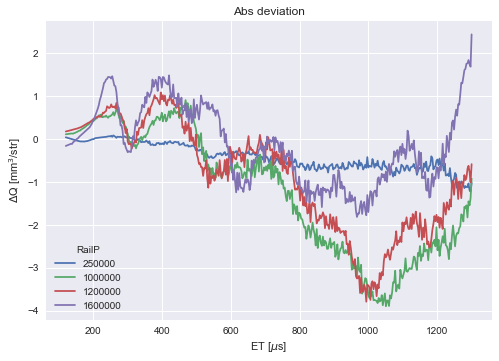

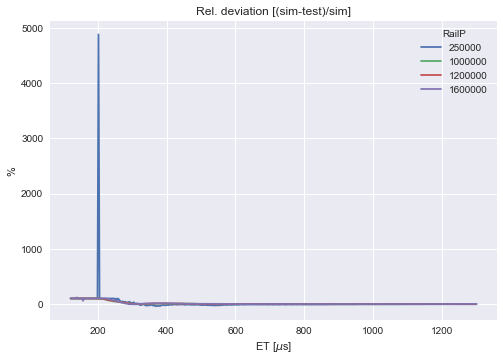

In [3]:
testdf.columns=testdf.columns.map(float)

dfp=ff-testdf
dfp.filter(items=[250000,1000000,1200000,1600000]).plot()
plt.xlabel(r"ET [$\mu$s]")
plt.ylabel(r"$\Delta$Q [mm$^3$/str]")
plt.title('Abs deviation')
ppdf=dfp/ff*100
ppdf.filter(items=[250000,1000000,1200000,1600000]).plot()
plt.xlabel(r"ET [$\mu$s]")
plt.ylabel("%")
plt.title('Rel. deviation [(sim-test)/sim]')